# Emotion Classifier

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization, Activation, Rescaling
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from math import ceil

## 0. Setup

In [2]:
train = True
width = 48
height = 48
export = False
model_name = ''

## 1. Data Preparation

In [3]:
data = pd.read_csv('../data/emotion/fer2013.csv')
labels = pd.read_csv('../data/emotion/fer2013new.csv')

classes = ['neutral', 'happiness', 'surprise', 'sadness', 'anger', 
           'disgust', 'fear', 'contempt', 'unknown', 'NF']

n_samples = len(data)
y = np.array(labels[classes])
X = np.zeros((n_samples, width, height, 1))
for i in range(n_samples):
    X[i] = np.fromstring(data['pixels'][i], dtype=int, sep=' ').reshape((height, width, 1))

In [4]:
# Using mask to remove unknown or NF images
y_mask = y.argmax(axis=-1)
mask = y_mask < classes.index('unknown')
X = X[mask]
y = y[mask]

# Convert to probabilities between 0 and 1
y = y[:, :-2] * 0.1

# Add contempt to neutral and remove it
y[:, 0] += y[:, 7]
y = y[:, :7]

In [5]:
test_size = ceil(len(X) * 0.1)

# Split Data
x_train, x_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=test_size, 
                                                    random_state=42)

x_train, x_val, y_train, y_val = train_test_split(x_train, 
                                                  y_train, 
                                                  test_size=test_size, 
                                                  random_state=42)

In [6]:
shift = 0.1
datagen = ImageDataGenerator(rotation_range=20,
                             horizontal_flip=True,
                             height_shift_range=shift,
                             width_shift_range=shift)

datagen.fit(x_train)

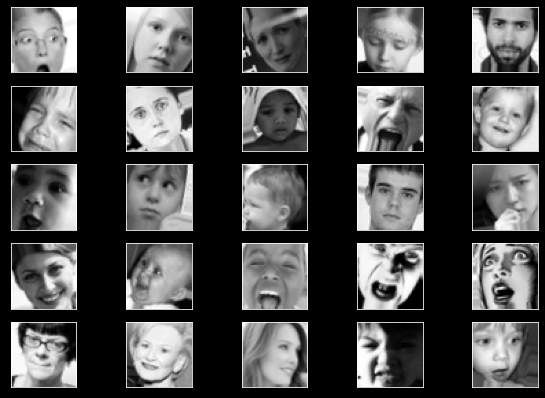

In [7]:
it = datagen.flow(x_train, y_train, batch_size=1)
plt.figure(figsize=(10, 7))

for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(it.next()[0][0], cmap='gray')

plt.show()

## 2. Model Training

In [8]:
epochs = 100
batch_size = 64

print("X_train shape: " + str(x_train.shape))
print("Y_train shape: " + str(y_train.shape))
print("X_test shape: " + str(x_test.shape))
print("Y_test shape: " + str(y_test.shape))
print("X_val shape: " + str(x_val.shape))
print("Y_val shape: " + str(y_val.shape))

X_train shape: (28390, 48, 48, 1)
Y_train shape: (28390, 7)
X_test shape: (3549, 48, 48, 1)
Y_test shape: (3549, 7)
X_val shape: (3549, 48, 48, 1)
Y_val shape: (3549, 7)


In [9]:
model = Sequential()
model.add(Rescaling(1./255, input_shape=(width, height, 1)))
model.add(Conv2D(64, kernel_size=(3, 3)))
model.add(BatchNormalization())
model.add(Activation(activation='relu'))
model.add(Conv2D(64, kernel_size=(3, 3)))
model.add(BatchNormalization())
model.add(Activation(activation='relu'))
model.add(Dropout(0.5))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Conv2D(128, kernel_size=(3, 3)))
model.add(BatchNormalization())
model.add(Activation(activation='relu'))
model.add(Conv2D(128, kernel_size=(3, 3)))
model.add(BatchNormalization())
model.add(Activation(activation='relu'))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Conv2D(256, kernel_size=(3, 3)))
model.add(BatchNormalization())
model.add(Activation(activation='relu'))
model.add(Conv2D(256, kernel_size=(3, 3)))
model.add(BatchNormalization())
model.add(Activation(activation='relu'))
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(7, activation='softmax'))

model.summary()
model.compile(optimizer=Adam(learning_rate=0.0001), 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 48, 48, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 46, 46, 64)        640       
_________________________________________________________________
batch_normalization (BatchNo (None, 46, 46, 64)        256       
_________________________________________________________________
activation (Activation)      (None, 46, 46, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 44, 44, 64)        36928     
_________________________________________________________________
batch_normalization_1 (Batch (None, 44, 44, 64)        256       
_________________________________________________________________
activation_1 (Activation)    (None, 44, 44, 64)        0

In [10]:
train_progress = None

if train:
    early_stopping = EarlyStopping(patience=10,
                                   verbose=2,
                                   restore_best_weights=True)
    
    train_progress = model.fit(datagen.flow(x_train, y_train, batch_size=batch_size), 
                               epochs=epochs, 
                               steps_per_epoch=len(x_train) // batch_size, 
                               validation_data=(x_val, y_val), 
                               verbose=2,
                               callbacks=[early_stopping])
    
    test_loss, test_acc = model.evaluate(x_test, y_test, batch_size=batch_size)

Epoch 1/100
443/443 - 144s - loss: 0.3483 - accuracy: 0.4058 - val_loss: 0.3999 - val_accuracy: 0.3810
Epoch 2/100
443/443 - 117s - loss: 0.3124 - accuracy: 0.5229 - val_loss: 0.2864 - val_accuracy: 0.5948
Epoch 3/100
443/443 - 121s - loss: 0.2877 - accuracy: 0.5865 - val_loss: 0.2896 - val_accuracy: 0.6030
Epoch 4/100
443/443 - 119s - loss: 0.2708 - accuracy: 0.6254 - val_loss: 0.2570 - val_accuracy: 0.6698
Epoch 5/100
443/443 - 118s - loss: 0.2577 - accuracy: 0.6569 - val_loss: 0.2439 - val_accuracy: 0.7016
Epoch 6/100
443/443 - 115s - loss: 0.2481 - accuracy: 0.6777 - val_loss: 0.2354 - val_accuracy: 0.7196
Epoch 7/100
443/443 - 117s - loss: 0.2421 - accuracy: 0.6927 - val_loss: 0.2375 - val_accuracy: 0.6954
Epoch 8/100
443/443 - 116s - loss: 0.2359 - accuracy: 0.7054 - val_loss: 0.2232 - val_accuracy: 0.7343
Epoch 9/100
443/443 - 113s - loss: 0.2306 - accuracy: 0.7225 - val_loss: 0.2254 - val_accuracy: 0.7267
Epoch 10/100
443/443 - 114s - loss: 0.2273 - accuracy: 0.7338 - val_loss:

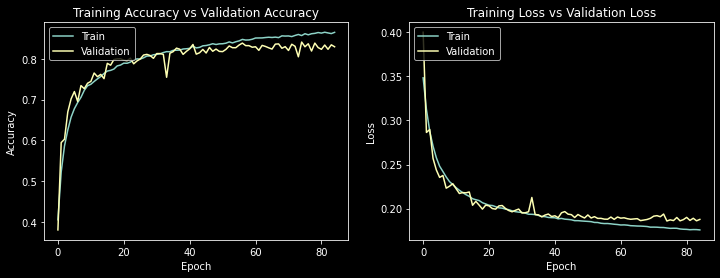

In [11]:
if train_progress:
    fig, ax = plt.subplots(1, 2)
    train_acc = train_progress.history['accuracy']
    train_loss = train_progress.history['loss']
    fig.set_size_inches(12, 4)

    ax[0].plot(train_progress.history['accuracy'])
    ax[0].plot(train_progress.history['val_accuracy'])
    ax[0].set_title('Training Accuracy vs Validation Accuracy')
    ax[0].set_ylabel('Accuracy')
    ax[0].set_xlabel('Epoch')
    ax[0].legend(['Train', 'Validation'], loc='upper left')

    ax[1].plot(train_progress.history['loss'])
    ax[1].plot(train_progress.history['val_loss'])
    ax[1].set_title('Training Loss vs Validation Loss')
    ax[1].set_ylabel('Loss')
    ax[1].set_xlabel('Epoch')
    ax[1].legend(['Train', 'Validation'], loc='upper left')

    plt.show()

In [12]:
if export:
    model.save(f'../models/{model_name}.h5')